## imports and setting up the environment

In [1]:
import pyannote

# database related imports
from pyannote.database import registry, FileFinder

# training related imports
from pyannote.audio import Pipeline, Model
from pyannote.audio import Inference
from pyannote.audio.tasks import SpeakerDiarization
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from types import MethodType
from torch.optim import Adam

# metrics related imports
from pyannote.metrics.diarization import DiarizationErrorRate

# other
import os

huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
registry.load_database("database.yml")

protocol = registry.get_protocol("BP.SpeakerDiarization.VlaamseAudio", {"audio":FileFinder()})

for file in protocol.train():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\database\registry.py:499: UserWarning: Replacing existing BP.SpeakerDiarization.VlaamseAudio protocol by the one defined in 'C:\Users\verho\Documents\School\2024-2025\Bacherlorproef\bp-stemmen-onderscheiden\pyannote\database.yml'.
  warnings.warn(


In [3]:
database = registry.get_database("BP")

database.get_tasks()

['SpeakerDiarization']

In [4]:
protocol.__class__

pyannote.database.custom.BP__SpeakerDiarization__VlaamseAudio

## pretrained pyannote pipeline

In [5]:
# get the model from the pipeline
pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=huggingface_token)


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\inspect.py:1007: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


current error rate of the pipeline

In [6]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 0.0% for the pretrained model


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\core\notebook.py:181: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(self.crop)


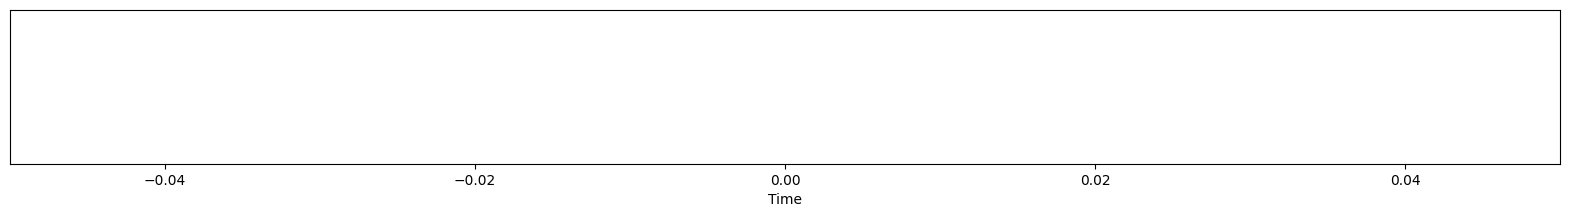

In [7]:
file["annotation"]

## train the model

In [54]:
pretrained_segm_model = Model.from_pretrained("pyannote/segmentation", use_auth_token=huggingface_token)
output_dir = "./models"

task = SpeakerDiarization(
    protocol=protocol,
    batch_size=32,
    vad_loss="bce"
)

pretrained_segm_model.task = task
pretrained_segm_model.prepare_data()
pretrained_segm_model.setup()

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\verho\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\660b9e20307a2b0cdb400d0f80aadc04a701fc54\pytorch_model.bin`


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.6.0+cpu. Bad things might happen unless you revert torch to 1.x.


   -   6.33% of all chunks contain no speech at all.
   -  82.41% contain 1 speaker or less
   -  98.73% contain 2 speakers or less
   - 100.00% contain 3 speakers or less
Setting `max_speakers_per_chunk` to 2. You can override this value (or avoid this estimation step) by passing `max_speakers_per_chunk=2` to the task constructor.


C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\audio\core\model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning, it is recommended to train task-dependent layers for a few epochs before training the whole model: ['activation', 'classifier'].
  warnings.warn(msg)


In [55]:
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)


In [58]:
pretrained_segm_model.configure_optimizers = MethodType(configure_optimizers, pretrained_segm_model)

In [62]:
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False
)

In [63]:
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False
)

In [64]:
callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [66]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=10,
    gradient_clip_val=0.5
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [67]:
trainer.fit(pretrained_segm_model)

┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃      In sizes ┃                           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 32000] │                        [1, 60, 115] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │  [1, 115, 60] │   [[1, 115, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │               │                           1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │             ? │                                   ? │
│ 3 │ classifier        │ Linear           │    258 │ train │ [1, 115, 128] │                         [1, 115, 2] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │   [1, 115, 2] │                         [1, 115, 2] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │             ? │                                   ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴───────────────┴─────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\verho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting 
`persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.

PicklingError: Can't pickle <class 'pyannote.database.registry.BP'>: attribute lookup BP on pyannote.database.registry failed